In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from datetime import datetime
import time


from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import svm


sns.set()

## Look datas

In [108]:
df_hero_names = pd.read_csv("input/dota-2-matches/hero_names.csv")
df_hero_names= df_hero_names.drop("name",axis=1)
df_hero_names['hero_id'] = df_hero_names.index

In the csv file, there is an error: hero_id 24 does not exist. To fix this, we will set it as the index, which will result in a slight offset compared to the original csv. However, this is not very important.

In [109]:
df_hero_names

,hero_id,localized_name
0,0,Anti-Mage
1,1,Axe
2,2,Bane
3,3,Bloodseeker
4,4,Crystal Maiden
...,...,...
107,107,Terrorblade
108,108,Phoenix
109,109,Oracle
110,110,Winter Wyvern


In [110]:
df_chat = pd.read_csv("input/dota-2-matches/chat.csv")
df_chat

,match_id,key,slot,time,unit
0,0,force it,6,-8,6k Slayer
1,0,space created,1,5,Monkey
2,0,hah,1,6,Monkey
3,0,ez 500,6,9,6k Slayer
4,0,mvp ulti,4,934,Kira
...,...,...,...,...,...
1439483,49999,ez,8,2796,DamN.Pussy_Jr
1439484,49999,ya ya so ezx,1,2796,StopDancing
1439485,49999,ez,8,2797,DamN.Pussy_Jr
1439486,49999,hahaha,1,2798,StopDancing


In [111]:
df_match = pd.read_csv("input/dota-2-matches/match.csv")
df_match

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155
1,1,1446753078,2582,0,1846,63,0,221,22,False,0,2,154
2,2,1446764586,2716,256,1972,63,48,190,22,False,0,0,132
3,3,1446765723,3085,4,1924,51,3,40,22,False,0,0,191
4,4,1446796385,1887,2047,0,0,63,58,22,True,0,0,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,1447829192,3025,1824,0,0,63,117,22,True,0,0,111
49996,49996,1447829181,1451,1982,384,48,63,147,22,True,0,0,204
49997,49997,1447829197,2672,1830,0,0,63,130,22,True,0,0,111
49998,49998,1447829189,2211,1982,4,3,63,645,22,True,0,0,151


In [112]:
df_player_ratings = pd.read_csv("input/dota-2-matches/player_ratings.csv")
df_player_ratings

,account_id,total_wins,total_matches,trueskill_mu,trueskill_sigma
0,236579,14,24,27.868035,5.212361
1,-343,1,1,26.544163,8.065475
2,-1217,1,1,26.521103,8.114989
3,-1227,1,1,27.248025,8.092217
4,-1284,0,1,22.931016,8.092224
...,...,...,...,...,...
834221,-298722891,1,1,27.643145,8.013786
834222,106173,0,1,23.069381,7.998792
834223,312076,1,1,28.217084,7.889176
834224,-299193988,0,2,22.406145,7.851303


The player_ratings csv file could have made our task easier, but the account IDs used in it are not the same as those used in players.csv.

In [113]:
df_purchase_log = pd.read_csv("input/dota-2-matches/purchase_log.csv")
df_purchase_log

,item_id,time,player_slot,match_id
0,44,-81,0,0
1,29,-63,0,0
2,43,6,0,0
3,84,182,0,0
4,46,197,0,0
...,...,...,...,...
18193740,141,2256,132,49999
18193741,29,2448,132,49999
18193742,48,2483,132,49999
18193743,40,2494,132,49999


In [114]:
df_cluster_regions = pd.read_csv("input/dota-2-matches/cluster_regions.csv")
df_cluster_regions

,cluster,region
0,111,US WEST
1,112,US WEST
2,113,US WEST
3,121,US EAST
4,122,US EAST
5,123,US EAST
6,124,US EAST
7,131,EUROPE
8,132,EUROPE
9,133,EUROPE


In [115]:
df_players = pd.read_csv("input/dota-2-matches/players.csv")
df_players

,match_id,account_id,hero_id,player_slot,gold,gold_spent,gold_per_min,xp_per_min,kills,deaths,...,unit_order_glyph,unit_order_eject_item_from_stash,unit_order_cast_rune,unit_order_ping_ability,unit_order_move_to_direction,unit_order_patrol,unit_order_vector_target_position,unit_order_radar,unit_order_set_item_combine_lock,unit_order_continue
0,0,0,86,0,3261,10960,347,362,9,3,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,0,1,51,1,2954,17760,494,659,13,3,...,NaN,NaN,NaN,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,83,2,110,12195,350,385,0,4,...,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN,NaN
3,0,2,11,3,1179,22505,599,605,8,4,...,1.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,3,67,4,3307,23825,613,762,20,3,...,3.0,NaN,NaN,23.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,49999,0,100,128,2718,17735,468,626,16,9,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
499996,49999,0,9,129,3755,20815,507,607,12,6,...,1.0,NaN,NaN,15.0,NaN,NaN,NaN,NaN,NaN,NaN
499997,49999,0,90,130,1059,16225,371,404,5,3,...,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN
499998,49999,0,73,131,3165,31015,780,703,8,6,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
df_patch = pd.read_csv("input/dota-2-matches/patch_dates.csv")
df_patch

,patch_date,name
0,2010-12-24T00:00:00Z,6.70
1,2011-01-21T00:00:00Z,6.71
2,2011-04-27T00:00:00Z,6.72
3,2011-12-24T00:00:00Z,6.73
4,2012-03-10T00:00:00Z,6.74
5,2012-09-30T00:00:00Z,6.75
6,2012-10-21T00:00:00Z,6.76
7,2012-12-15T00:00:00Z,6.77
8,2013-05-30T00:00:00Z,6.78
9,2013-11-24T00:00:00Z,6.79


In this csv file, the date is in ISO format, whereas in the match file it is in integer format. It would be better to change it to the same format as in the match file to make future searches easier.

In [117]:
def change_iso_to_int(iso_timestamp):
    dt_object = datetime.strptime(iso_timestamp, '%Y-%m-%dT%H:%M:%SZ')
    int_timestamp = int(time.mktime(dt_object.timetuple()))
    return int_timestamp

We apply the function that we just created."

In [118]:
df_patch['patch_date_int'] = df_patch.apply(lambda row: change_iso_to_int(row['patch_date']),axis=1)
df_patch

,patch_date,name,patch_date_int
0,2010-12-24T00:00:00Z,6.70,1293145200
1,2011-01-21T00:00:00Z,6.71,1295564400
2,2011-04-27T00:00:00Z,6.72,1303855200
3,2011-12-24T00:00:00Z,6.73,1324681200
4,2012-03-10T00:00:00Z,6.74,1331334000
5,2012-09-30T00:00:00Z,6.75,1348956000
6,2012-10-21T00:00:00Z,6.76,1350770400
7,2012-12-15T00:00:00Z,6.77,1355526000
8,2013-05-30T00:00:00Z,6.78,1369864800
9,2013-11-24T00:00:00Z,6.79,1385247600


#### Given that our csv files have many columns, in order to determine which ones are most useful, we will perform an EDA (Exploratory Data Analysis).

In [119]:
df_eda = df_match.copy()
df_eda2 = df_match.copy()

In [120]:
df_eda1 = df_eda.merge(df_cluster_regions, on="cluster")
df_eda1

,match_id,start_time,duration,tower_status_radiant,tower_status_dire,barracks_status_dire,barracks_status_radiant,first_blood_time,game_mode,radiant_win,negative_votes,positive_votes,cluster,region
0,0,1446750112,2375,1982,4,3,63,1,22,True,0,1,155,SINGAPORE
1,5,1446798766,1574,2047,4,3,63,113,22,True,0,0,155,SINGAPORE
2,29,1446910512,3388,4,1796,63,51,80,22,False,0,0,155,SINGAPORE
3,32,1446917368,1749,2047,4,3,63,4,22,True,0,0,155,SINGAPORE
4,34,1446919403,1953,1974,0,0,63,47,22,True,0,0,155,SINGAPORE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,28787,1447608679,1533,4,2047,63,3,0,22,False,0,0,161,DUBAI
49996,36032,1447683459,2477,0,2038,63,0,77,22,False,0,0,161,DUBAI
49997,36287,1447686751,2321,1975,384,48,63,114,22,True,0,0,161,DUBAI
49998,36584,1447690241,2198,2046,0,3,63,86,22,True,0,0,161,DUBAI


We check if there are any null values in match + cluster df


In [121]:
df_eda1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   match_id                 50000 non-null  int64 
 1   start_time               50000 non-null  int64 
 2   duration                 50000 non-null  int64 
 3   tower_status_radiant     50000 non-null  int64 
 4   tower_status_dire        50000 non-null  int64 
 5   barracks_status_dire     50000 non-null  int64 
 6   barracks_status_radiant  50000 non-null  int64 
 7   first_blood_time         50000 non-null  int64 
 8   game_mode                50000 non-null  int64 
 9   radiant_win              50000 non-null  bool  
 10  negative_votes           50000 non-null  int64 
 11  positive_votes           50000 non-null  int64 
 12  cluster                  50000 non-null  int64 
 13  region                   50000 non-null  object
dtypes: bool(1), int64(12), object(1)
memor

We check if there are any null values in players df

In [122]:
df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 73 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   match_id                           500000 non-null  int64  
 1   account_id                         500000 non-null  int64  
 2   hero_id                            500000 non-null  int64  
 3   player_slot                        500000 non-null  int64  
 4   gold                               500000 non-null  int64  
 5   gold_spent                         500000 non-null  int64  
 6   gold_per_min                       500000 non-null  int64  
 7   xp_per_min                         500000 non-null  int64  
 8   kills                              500000 non-null  int64  
 9   deaths                             500000 non-null  int64  
 10  assists                            500000 non-null  int64  
 11  denies                             5000

In [123]:
df_players2 = df_players.copy()

#### We will begin our preprocessing by handling NULL values.

In [124]:
def cek_null(df):
    col_na = df.isnull().sum().sort_values(ascending=True)
    percent = col_na / len(df)
    
    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])
    
    if (missing_data[missing_data['Total'] > 0].shape[0] == 0):
        print("missing value dataset")
        
    else:
        print(missing_data[missing_data['Total'] > 0])


#### Remove any column that has "unit" in their name

In [125]:
col_to_remove = []
for col in df_players2.columns:
    if 'unit' in col:
        col_to_remove.append(col)
# print(col_to_remove)

In [126]:
df_players2 = df_players2.drop(col_to_remove,axis=1)

#### Fill the rest with 0

In [127]:
df_players_filled = df_players2.copy()
df_players_filled.fillna(0,inplace=True)

### Filling null complete for df_players

In [128]:
cek_null(df_players_filled)

missing value dataset


#### Only use  certain columns from df_players

In [129]:
df_p_eda_hero = df_players_filled[['match_id','account_id','hero_id',"gold","gold_spent","xp_per_min"]]
df_p_eda_hero

,match_id,account_id,hero_id,gold,gold_spent,xp_per_min
0,0,0,86,3261,10960,362
1,0,1,51,2954,17760,659
2,0,0,83,110,12195,385
3,0,2,11,1179,22505,605
4,0,3,67,3307,23825,762
...,...,...,...,...,...,...
499995,49999,0,100,2718,17735,626
499996,49999,0,9,3755,20815,607
499997,49999,0,90,1059,16225,404
499998,49999,0,73,3165,31015,703


#### The dataset works such that for each match_id, the first 5 account_ids belong to the is_radiant team.


> We could have also looked at the player_slot to see if it's between 0 and 5, otherwise the player is on the Dire team.

In [130]:
def check_player_radiant(row):
    if (row.name%10) < 5:
        return True
    return False

In [131]:
df_p_eda_hero["is_radiant"] = df_p_eda_hero.apply(lambda row: check_player_radiant(row), axis=1)

C:\Users\walid\AppData\Local\Temp\ipykernel_22680\3621995373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p_eda_hero["is_radiant"] = df_p_eda_hero.apply(lambda row: check_player_radiant(row), axis=1)


#### Create a new feature of xp_sum, 

In [132]:
df_p_eda_hero["xp_sum"] = df_players_filled.apply(lambda row: row['xp_hero']+row['xp_other']+row['xp_creep']+row['xp_roshan'], axis=1)

C:\Users\walid\AppData\Local\Temp\ipykernel_22680\1948719207.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p_eda_hero["xp_sum"] = df_players_filled.apply(lambda row: row['xp_hero']+row['xp_other']+row['xp_creep']+row['xp_roshan'], axis=1)


In [133]:
df_p_eda_hero

,match_id,account_id,hero_id,gold,gold_spent,xp_per_min,is_radiant,xp_sum
0,0,0,86,3261,10960,362,True,14363.0
1,0,1,51,2954,17760,659,True,26125.0
2,0,0,83,110,12195,385,True,15257.0
3,0,2,11,1179,22505,605,True,24000.0
4,0,3,67,3307,23825,762,True,30201.0
...,...,...,...,...,...,...,...,...
499995,49999,0,100,2718,17735,626,False,29124.0
499996,49999,0,9,3755,20815,607,False,28243.0
499997,49999,0,90,1059,16225,404,False,18817.0
499998,49999,0,73,3165,31015,703,False,32701.0


### Merging with hero

> As mentioned earlier, the hero_names csv file is flawed because it is missing hero_id 24. We will need to fix this before adding it to the rest of the data.

In [134]:
def fix_hero_id(row):
    if row['hero_id'] >23:
        return row['hero_id']-1
    else:
        return row['hero_id']

In [135]:
df_p_eda_hero['hero_id']=df_p_eda_hero.apply(lambda row:fix_hero_id(row),axis=1)

C:\Users\walid\AppData\Local\Temp\ipykernel_22680\4224521913.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_p_eda_hero['hero_id']=df_p_eda_hero.apply(lambda row:fix_hero_id(row),axis=1)


In [136]:
df_p_eda_hero = df_p_eda_hero.merge(df_hero_names,on="hero_id")

In [137]:
# Sort by match id
df_p_eda_hero = df_p_eda_hero.sort_values(by="match_id", ascending=True).reset_index()

In [138]:
cek_null(df_p_eda_hero)

missing value dataset


> df_p_eda_hero is finally clean

In [139]:
df_eda2 = df_eda2.merge(df_p_eda_hero, on="match_id")

In [140]:
df_eda2.columns

Index(['match_id', 'start_time', 'duration', 'tower_status_radiant',
       'tower_status_dire', 'barracks_status_dire', 'barracks_status_radiant',
       'first_blood_time', 'game_mode', 'radiant_win', 'negative_votes',
       'positive_votes', 'cluster', 'index', 'account_id', 'hero_id', 'gold',
       'gold_spent', 'xp_per_min', 'is_radiant', 'xp_sum', 'localized_name'],
      dtype='object')

##  Heroes win rate

> To do this, we will only need to retrieve the hero used by a player, determine which team they are on, and whether their team won.

In [141]:
df_eda_hero_wr = df_eda2[["match_id","account_id","hero_id","localized_name","is_radiant","radiant_win"]]

In [142]:
df_eda_hero_wr["is_win"] = df_eda_hero_wr.apply(lambda row: not (row["is_radiant"] ^ row["radiant_win"])  ,axis=1)

C:\Users\walid\AppData\Local\Temp\ipykernel_22680\3880369255.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda_hero_wr["is_win"] = df_eda_hero_wr.apply(lambda row: not (row["is_radiant"] ^ row["radiant_win"])  ,axis=1)


In [143]:
#We will create a column to easily increment at each row.
df_eda_hero_wr["is_played"] = 1

C:\Users\walid\AppData\Local\Temp\ipykernel_22680\2450672230.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda_hero_wr["is_played"] = 1


In [144]:
df_eda_hero_wr

,match_id,account_id,hero_id,localized_name,is_radiant,radiant_win,is_win,is_played
0,0,0,85,Disruptor,True,True,True,1
1,0,5,45,Viper,False,True,False,1
2,0,4,105,Earth Spirit,False,True,False,1
3,0,2,11,Phantom Lancer,True,True,True,1
4,0,0,101,Elder Titan,False,True,False,1
...,...,...,...,...,...,...,...,...
499995,49999,0,34,Necrophos,True,False,False,1
499996,49999,0,72,Invoker,False,False,True,1
499997,49999,0,99,Skywrath Mage,False,False,True,1
499998,49999,0,67,Doom,True,False,False,1


> The is_radiant is no longer grouped as teams, due too merging with radiant_win feature. But, sorting with match_id produced a grouped match_id which is good enough and importantly, the is_radiant feature is still correct

#### Building the features

In [145]:
df_eda_hero_wr1=df_eda_hero_wr.groupby(by=["localized_name"])[["is_win","is_played"]].sum().reset_index()

In [146]:
df_eda_hero_wr1['win_rate'] = df_eda_hero_wr1['is_win']/df_eda_hero_wr1['is_played']*100

In [147]:
df_eda_hero_highest = df_eda_hero_wr1.sort_values(by='win_rate',ascending=False).head(10)
df_eda_hero_highest

,localized_name,is_win,is_played,win_rate
31,Enchantress,3048,5161,59.058322
2,Ancient Apparition,3886,6660,58.348348
22,Death Prophet,4518,7794,57.967667
74,Rubick,3385,5951,56.881196
29,Elder Titan,1882,3310,56.858006
85,Spirit Breaker,2444,4302,56.810786
104,Warlock,3364,5969,56.357849
73,Riki,2625,4687,56.005974
90,Tidehunter,6254,11181,55.934174
41,Kunkka,2547,4589,55.502288


In [148]:
df_eda_hero_lowest = df_eda_hero_wr1.sort_values(by='win_rate',ascending=True).head(10)
df_eda_hero_lowest

,localized_name,is_win,is_played,win_rate
3,Anti-Mage,6,37,16.216216
45,Lifestealer,1357,3344,40.580144
48,Lone Druid,569,1395,40.788530
35,Huskar,415,1016,40.846457
10,Bounty Hunter,613,1486,41.251682
87,Sven,1000,2407,41.545492
69,Pudge,743,1761,42.191936
47,Lion,3537,8255,42.846760
15,Chaos Knight,419,967,43.329886
6,Bane,1999,4601,43.447077


In [149]:
df_eda_hero_least_played = df_eda_hero_wr1.sort_values(by='is_played',ascending=True).head(10)
df_eda_hero_least_played

,localized_name,is_win,is_played,win_rate
3,Anti-Mage,6,37,16.216216
84,Spectre,271,579,46.804836
42,Legion Commander,428,838,51.073986
76,Shadow Demon,464,931,49.838883
15,Chaos Knight,419,967,43.329886
11,Brewmaster,499,985,50.659898
82,Slark,495,997,49.648947
40,Keeper of the Light,452,1001,45.154845
107,Winter Wyvern,480,1009,47.571853
35,Huskar,415,1016,40.846457


In [150]:
df_eda_hero_most_played = df_eda_hero_wr1.sort_values(by='is_played',ascending=False).head(10)
df_eda_hero_most_played

,localized_name,is_win,is_played,win_rate
110,Zeus,10026,20881,48.014942
66,Phantom Lancer,8785,17007,51.655201
79,Silencer,5733,11676,49.100719
39,Juggernaut,5700,11323,50.340016
90,Tidehunter,6254,11181,55.934174
101,Venomancer,4744,10590,44.796978
54,Mirana,5362,10394,51.587454
80,Skywrath Mage,5269,10306,51.125558
36,Invoker,5095,9823,51.868065
72,Razor,4652,9447,49.243146


### Visualizations

#### Graph Highest Win Rate

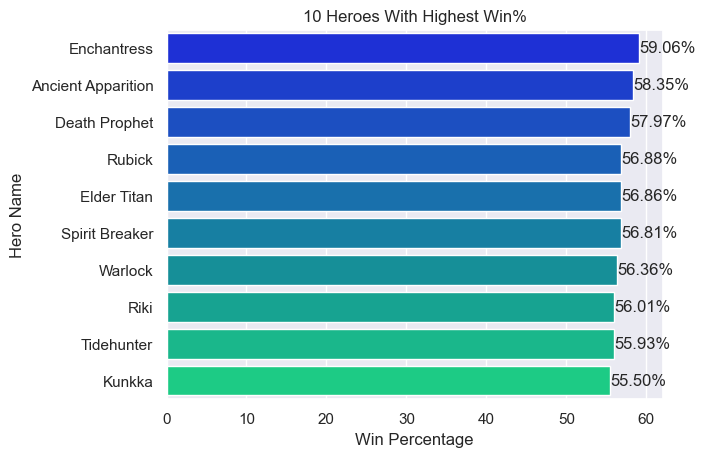

In [151]:
plt.title("10 Heroes With Highest Win%")
# Plot the data
ax = sns.barplot(x='win_rate', y='localized_name', data=df_eda_hero_highest, orient='h', palette='winter')
ax.set_xlabel('Win Percentage')
ax.set_ylabel('Hero Name')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f%%')

# Show the plot
plt.show()


#### Graph Lowest Win Rate

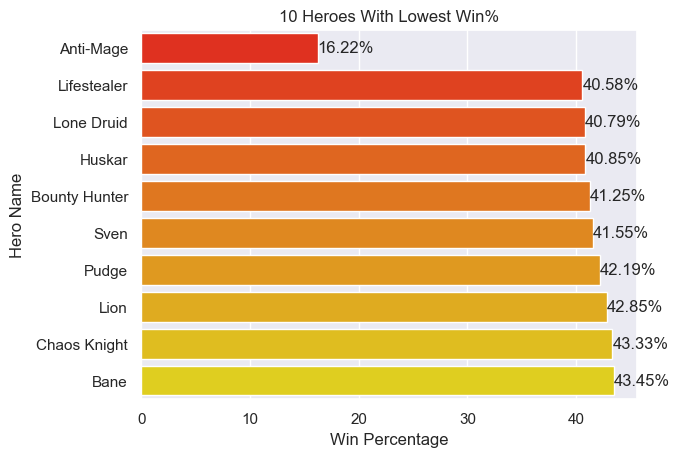

In [152]:
plt.title("10 Heroes With Lowest Win%")
# Plot the data
ax = sns.barplot(x='win_rate', y='localized_name', data=df_eda_hero_lowest, orient='h',palette='autumn')
ax.set_xlabel('Win Percentage')
ax.set_ylabel('Hero Name')
for container in ax.containers:
    ax.bar_label(container,fmt='%.2f%%')

# Show the plot
plt.show()


#### Graph Least Played

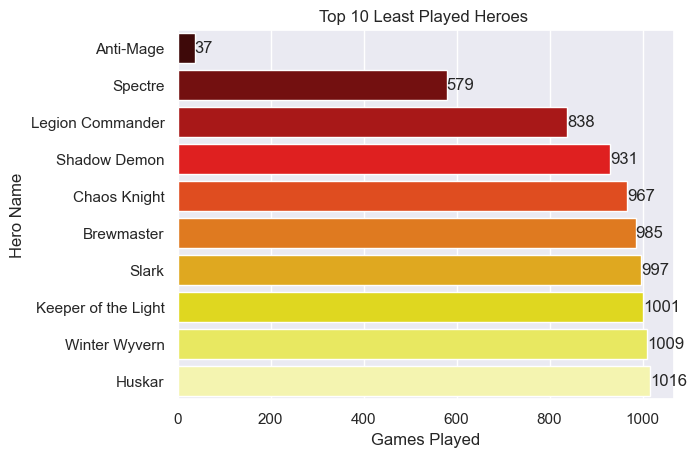

In [153]:
plt.title("Top 10 Least Played Heroes ")
# Plot the data
ax = sns.barplot(x='is_played', y='localized_name', data=df_eda_hero_least_played, orient='h',palette='hot')
ax.set_xlabel('Games Played')
ax.set_ylabel('Hero Name')
for container in ax.containers:
    ax.bar_label(container)

# Show the plot
plt.show()


#### Graph Most Played

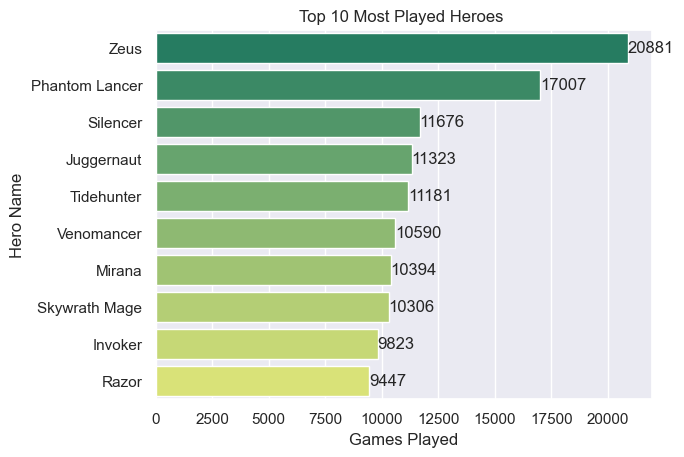

In [154]:
plt.title("Top 10 Most Played Heroes ")
# Plot the data
ax = sns.barplot(x='is_played', y='localized_name', data=df_eda_hero_most_played, orient='h',palette='summer')
ax.set_xlabel('Games Played')
ax.set_ylabel('Hero Name')
for container in ax.containers:
    ax.bar_label(container)

# Show the plot
plt.show()


> Every game has a chance of overlapping heroes picked

## Most used words in chat

In [155]:
df_eda1.columns

Index(['match_id', 'start_time', 'duration', 'tower_status_radiant',
       'tower_status_dire', 'barracks_status_dire', 'barracks_status_radiant',
       'first_blood_time', 'game_mode', 'radiant_win', 'negative_votes',
       'positive_votes', 'cluster', 'region'],
      dtype='object')

In [156]:
df_chat_grouped=df_chat.groupby(by=["key"])[["match_id"]].count().reset_index()

> Match id is count of chat occurence

In [157]:
df_chat_grouped=df_chat_grouped.sort_values(by='match_id',ascending=False).reset_index()

#### Figuring out chat message distribution

In [158]:
df_chat_grouped[df_chat_grouped["match_id"] < 2].count()['key']/df_chat_grouped.shape[0]

0.9086179492598586

> The data is incredibly skewed. 90% of chat messages only occurs once

#### Let's look at similar messages that are written differently

In [159]:
df_chat_grouped.shape

(690814, 3)

> 

Let's first try with gg since it is a message commonly used in games.

In [160]:
df_chat_grouped[df_chat_grouped["key"].str.contains("gg")]['match_id'].sum()

123291

In [161]:
df_chat_grouped[df_chat_grouped["key"] == "gg"]['match_id']

0    65412
Name: match_id, dtype: int64

In [162]:
gg = "gg"

In [163]:
df_chat_grouped[(df_chat_grouped["key"].str.contains(fr'\b{gg}\b')) ]['match_id'].sum()

100179

#### Method to combine similar chats and add it to the most chat ones

In [164]:
df_chat_similar = df_chat_grouped.rename(columns={"key":"chat","match_id":"occurence"}).drop("index",axis=1)
# df_chat_similar.head(50)['chat'].tolist()

In [165]:
cutter = ['gg','wp','lol','thanks','ez','noob','pussy','asshole','fuck','bitch','ty','bot','afk','smurf','troll']

In [166]:
def check_contains(row):
    output=""
    for item in cutter:
        con0 = item != row['chat']
        con1 = bool(re.search(fr'\b{item.lower()} \w+', row['chat'].lower()))  # standalone words in front
        con2 = bool(re.search(fr'\w+ {item.lower()}\b', row['chat'].lower()))  # standalone words in back
        con3 = bool(re.search(fr'\w+ {item.lower()} \w+', row['chat'].lower()))  # standalone words in middle
        con4 = bool(re.search(fr'\b{item.lower()}\w+', row['chat'].lower()))  # infront of a word
        con5 = bool(re.search(fr'\w+ {item.lower()}[!=?-] \w+', row['chat'].lower()))  # wordnumbersymbol middle
        con6 = bool(re.search(fr'\b{item.lower()}[!=?-] \w+', row['chat'].lower()))  # wordnumbersymbol front
        con7 = bool(re.search(fr'\w+ {item.lower()}[!=?-]\b', row['chat'].lower()))  # wordnumbersymbol back
        # Switch with item if matches with regex patters
        # Return the first match
        if (con1 or con2 or con3 or con4 or con5 or con6 or con7) and con0:
            return item
        else:
            # just dont do anything with it, but dont return just yet
            output= row['chat']
    return output
    # at the end after the function, make sure to group by the Text

## Takes 10 minutes approximatively

In [167]:
df_chat_similar['chat'] = df_chat_similar.apply(lambda row:check_contains(row),axis=1)
aggregation_functions = {'chat': 'first', 'occurence': 'sum'}

In [168]:
df_chat_similar=df_chat_similar.groupby(by=["chat"]).aggregate(aggregation_functions).reset_index(drop=True)

In [169]:
df_chat_similar=df_chat_similar.sort_values(by="occurence",ascending=False).reset_index(drop=True)

In [170]:
df_chat_similar[df_chat_similar["occurence"] ==2].count()['chat']/df_chat_similar.shape[0]

0.04401554559820183

In [171]:
df_chat_twice = df_chat_similar[df_chat_similar["occurence"] >=2]

In [172]:
chat_messages = ''
for row_index, row in df_chat_twice.iterrows():
    chat_messages += (row['chat']+" ")*row['occurence']

#### Let's use word cloud for visualizing most occuring chat messages

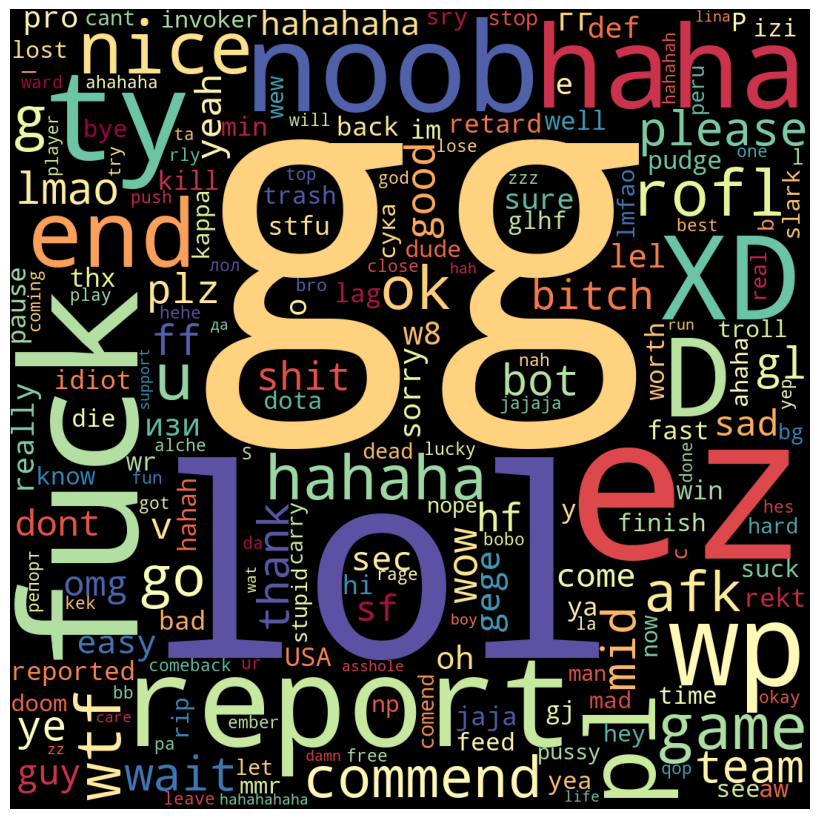

In [173]:
from wordcloud import WordCloud, STOPWORDS


wordcloud = WordCloud(width = 1080, height = 1080,
                background_color ='black',
                      colormap='Spectral',
                stopwords = STOPWORDS,collocations=False,
                min_font_size = 10).generate(chat_messages)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

> Interesting, look at all those toxicity hahahahah. I already knew that the result was going to be like that

## Modelling

### More Exploration of datas


In [174]:
columns_to_drop = df_eda2.columns.intersection(df_eda_hero_wr.columns)
df_eda_modified = df_eda2.drop(columns=columns_to_drop)
df_model_original = df_eda_modified.join(df_eda_hero_wr,how="outer")

df_model_original.shape

(500000, 24)

In [175]:
df_eda_hero_wr.columns

Index(['match_id', 'account_id', 'hero_id', 'localized_name', 'is_radiant',
       'radiant_win', 'is_win', 'is_played'],
      dtype='object')

In [176]:
df_model_original.columns

Index(['start_time', 'duration', 'tower_status_radiant', 'tower_status_dire',
       'barracks_status_dire', 'barracks_status_radiant', 'first_blood_time',
       'game_mode', 'negative_votes', 'positive_votes', 'cluster', 'index',
       'gold', 'gold_spent', 'xp_per_min', 'xp_sum', 'match_id', 'account_id',
       'hero_id', 'localized_name', 'is_radiant', 'radiant_win', 'is_win',
       'is_played'],
      dtype='object')

In [177]:
df_model_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   start_time               500000 non-null  int64  
 1   duration                 500000 non-null  int64  
 2   tower_status_radiant     500000 non-null  int64  
 3   tower_status_dire        500000 non-null  int64  
 4   barracks_status_dire     500000 non-null  int64  
 5   barracks_status_radiant  500000 non-null  int64  
 6   first_blood_time         500000 non-null  int64  
 7   game_mode                500000 non-null  int64  
 8   negative_votes           500000 non-null  int64  
 9   positive_votes           500000 non-null  int64  
 10  cluster                  500000 non-null  int64  
 11  index                    500000 non-null  int64  
 12  gold                     500000 non-null  int64  
 13  gold_spent               500000 non-null  int64  
 14  xp_p

In [178]:
df_model_original[df_model_original['hero_id']==11]['gold_spent'].mean()

18938.562356676663

In [179]:
df_model_original[df_model_original['hero_id']==11]['duration'].mean()

2434.263420944317

In [180]:
df_model_original[df_model_original['hero_id']==11]['xp_per_min'].mean()

572.8498265420121

<Axes: xlabel='gold_spent', ylabel='xp_per_min'>

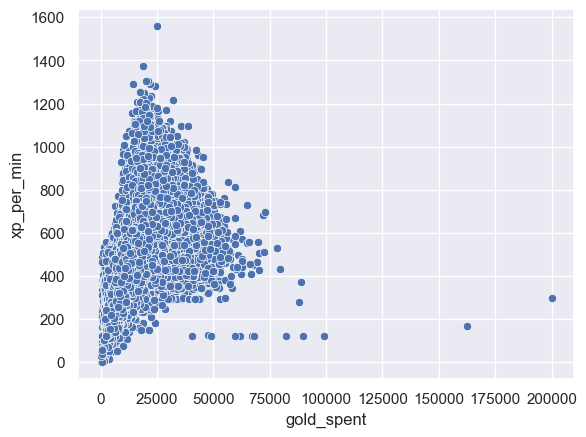

In [181]:
sns.scatterplot(x=df_model_original["gold_spent"],y=df_model_original["xp_per_min"])

<Axes: xlabel='gold_spent', ylabel='gold'>

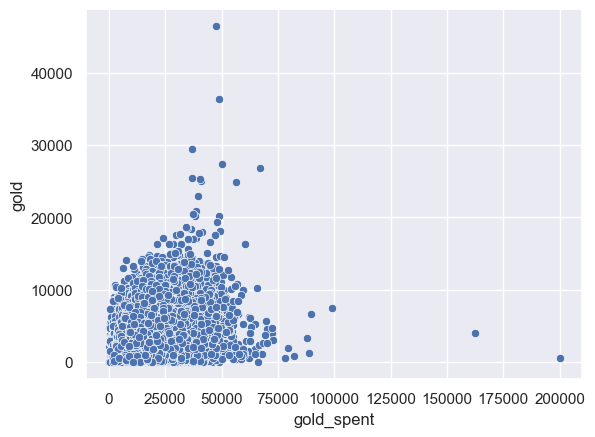

In [182]:
sns.scatterplot(x=df_model_original["gold_spent"],y=df_model_original["gold"])

<Axes: xlabel='gold_spent', ylabel='xp_sum'>

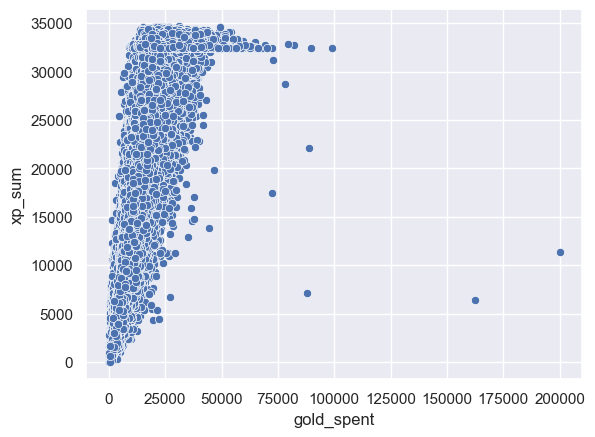

In [183]:
sns.scatterplot(x=df_model_original["gold_spent"],y=df_model_original["xp_sum"])

<Axes: xlabel='gold_spent', ylabel='duration'>

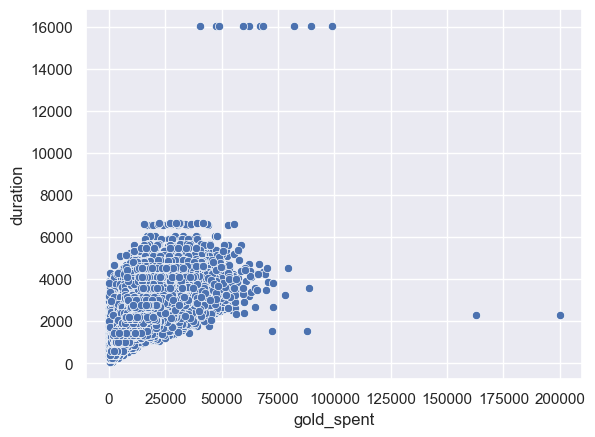

In [184]:
sns.scatterplot(x=df_model_original["gold_spent"],y=df_model_original["duration"])

<Axes: xlabel='tower_status_dire', ylabel='tower_status_radiant'>

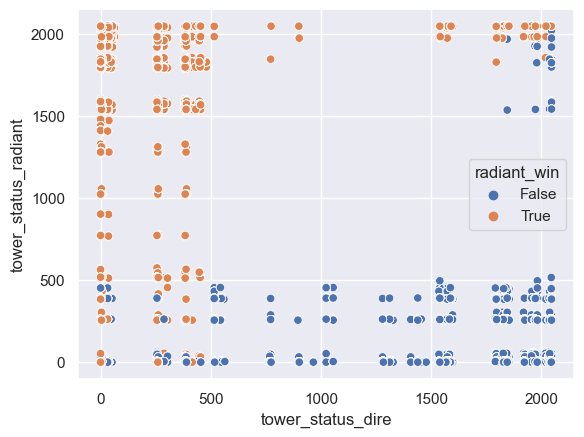

In [185]:
sns.scatterplot(x=df_model_original["tower_status_dire"],  y=df_model_original["tower_status_radiant"], hue=df_model_original["radiant_win"])

<Axes: xlabel='barracks_status_dire', ylabel='barracks_status_radiant'>

C:\Users\walid\AppData\Roaming\Python\Python310\site-packages\IPython\core\events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\walid\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


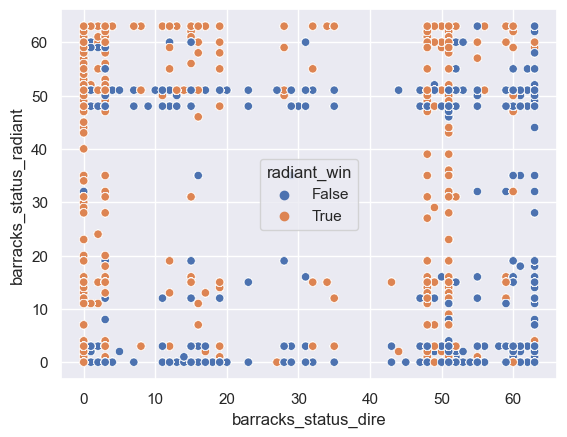

In [186]:
sns.scatterplot(x=df_model_original["barracks_status_dire"],  y=df_model_original["barracks_status_radiant"], hue=df_model_original["radiant_win"])

## 2. Predict Radiant win/not 

### Preprocessing

In [187]:
test_players = pd.read_csv('input/dota-2-matches/test_player.csv')
hero_names = pd.read_csv('input/dota-2-matches/hero_names.csv')

In [188]:
hero_df = pd.merge(test_players,hero_names, on = 'hero_id',how = 'left')
hero_df.set_index(['match_id','player_slot'],inplace = True)
hero_df.head(10)


account_id  hero_id                            name   
match_id player_slot                                                        
50000    0                117784       96           npc_dota_hero_centaur  \
         1                158361       84         npc_dota_hero_ogre_magi   
         2                158362       46  npc_dota_hero_templar_assassin   
         3                137970       85           npc_dota_hero_undying   
         4                  1090       39       npc_dota_hero_queenofpain   
         128                2391        9            npc_dota_hero_mirana   
         129                2393       75          npc_dota_hero_silencer   
         130                2394      106      npc_dota_hero_ember_spirit   
         131               36737       74           npc_dota_hero_invoker   
         132                2392       62     npc_dota_hero_bounty_hunter   

                         localized_name  
match_id player_slot                     
50000    0            Centaur Warrunner  
         1                    Ogre Magi  
         2             Templar Assassin  
         3                      Undying  
         4                Queen of Pain  
         128                     Mirana  
         129                   Silencer  
         130               Ember Spirit  
         131                    Invoker  
         132              Bounty Hunter

In [189]:
id_df = hero_df['hero_id'].unstack()
id_df.head()

player_slot,0,1,2,3,4,128,129,130,131,132
match_id,,,,,,,,,,
50000,96,84,46,85,39,9,75,106,74,62
50001,44,10,57,2,106,58,61,21,18,14
50002,74,7,42,99,88,69,8,25,26,79
50003,44,15,110,56,94,2,101,32,7,72
50004,98,26,73,51,46,2,106,50,65,21


In [190]:
name_df = hero_df['localized_name'].unstack()
name_df.head()

player_slot,0,1,2,3,4,128,129,130,131,132
match_id,,,,,,,,,,
50000,Centaur Warrunner,Ogre Magi,Templar Assassin,Undying,Queen of Pain,Mirana,Silencer,Ember Spirit,Invoker,Bounty Hunter
50001,Phantom Assassin,Morphling,Omniknight,Axe,Ember Spirit,Enchantress,Broodmother,Windranger,Sven,Pudge
50002,Invoker,Earthshaker,Wraith King,Bristleback,Nyx Assassin,Doom,Juggernaut,Lina,Lion,Shadow Demon
50003,Phantom Assassin,Razor,Phoenix,Clinkz,Medusa,Axe,Skywrath Mage,Riki,Earthshaker,Gyrocopter
50004,Timbersaw,Lion,Alchemist,Clockwerk,Templar Assassin,Axe,Ember Spirit,Dazzle,Batrider,Windranger


In [191]:
test_labels = pd.read_csv('input/dota-2-matches/test_labels.csv', index_col=0)
test_labels.head()

,radiant_win
match_id,
50000,0
50001,1
50002,0
50003,1
50004,0


In [192]:
new_test = pd.merge(test_labels,id_df,left_index = True,right_index = True)
new_test = pd.merge(new_test,name_df,left_index = True,right_index = True)
new_test.head()

,radiant_win,0_x,1_x,2_x,3_x,4_x,128_x,129_x,130_x,131_x,...,0_y,1_y,2_y,3_y,4_y,128_y,129_y,130_y,131_y,132_y
match_id,,,,,,,,,,,,,,,,,,,,,
50000,0,96,84,46,85,39,9,75,106,74,...,Centaur Warrunner,Ogre Magi,Templar Assassin,Undying,Queen of Pain,Mirana,Silencer,Ember Spirit,Invoker,Bounty Hunter
50001,1,44,10,57,2,106,58,61,21,18,...,Phantom Assassin,Morphling,Omniknight,Axe,Ember Spirit,Enchantress,Broodmother,Windranger,Sven,Pudge
50002,0,74,7,42,99,88,69,8,25,26,...,Invoker,Earthshaker,Wraith King,Bristleback,Nyx Assassin,Doom,Juggernaut,Lina,Lion,Shadow Demon
50003,1,44,15,110,56,94,2,101,32,7,...,Phantom Assassin,Razor,Phoenix,Clinkz,Medusa,Axe,Skywrath Mage,Riki,Earthshaker,Gyrocopter
50004,0,98,26,73,51,46,2,106,50,65,...,Timbersaw,Lion,Alchemist,Clockwerk,Templar Assassin,Axe,Ember Spirit,Dazzle,Batrider,Windranger


In [193]:
new_test.dropna(inplace = True)
new_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99985 entries, 50000 to 149999
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   radiant_win  99985 non-null  int64 
 1   0_x          99985 non-null  int64 
 2   1_x          99985 non-null  int64 
 3   2_x          99985 non-null  int64 
 4   3_x          99985 non-null  int64 
 5   4_x          99985 non-null  int64 
 6   128_x        99985 non-null  int64 
 7   129_x        99985 non-null  int64 
 8   130_x        99985 non-null  int64 
 9   131_x        99985 non-null  int64 
 10  132_x        99985 non-null  int64 
 11  0_y          99985 non-null  object
 12  1_y          99985 non-null  object
 13  2_y          99985 non-null  object
 14  3_y          99985 non-null  object
 15  4_y          99985 non-null  object
 16  128_y        99985 non-null  object
 17  129_y        99985 non-null  object
 18  130_y        99985 non-null  object
 19  131_y        99985 non-nu

In [194]:

tester = new_test.copy()

tester['radiant_id'] = [np.zeros(112) for _ in range(len(tester))]
tester['dire_id'] = [np.zeros(112) for _ in range(len(tester))]
tester['radiant_name'] = [[] for _ in range(len(tester))]
tester['dire_name'] = [[] for _ in range(len(tester))]


for ind in tester.index:
    for num in range(0,5):
        d = tester.loc[ind,str(num)+'_x']
        name = tester.loc[ind,str(num)+'_y']
        tester.loc[ind,'radiant_id'][d-1] = 1
        tester.loc[ind,'radiant_name'].append(name)
    for num in range(128,133):
        d = tester.loc[ind,str(num)+'_x']
        name = tester.loc[ind,str(num)+'_y']
        tester.loc[ind,'dire_id'][d-1] = 1
        tester.loc[ind,'dire_name'].append(name)

    

In [195]:
tester.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99985 entries, 50000 to 149999
Data columns (total 25 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   radiant_win   99985 non-null  int64 
 1   0_x           99985 non-null  int64 
 2   1_x           99985 non-null  int64 
 3   2_x           99985 non-null  int64 
 4   3_x           99985 non-null  int64 
 5   4_x           99985 non-null  int64 
 6   128_x         99985 non-null  int64 
 7   129_x         99985 non-null  int64 
 8   130_x         99985 non-null  int64 
 9   131_x         99985 non-null  int64 
 10  132_x         99985 non-null  int64 
 11  0_y           99985 non-null  object
 12  1_y           99985 non-null  object
 13  2_y           99985 non-null  object
 14  3_y           99985 non-null  object
 15  4_y           99985 non-null  object
 16  128_y         99985 non-null  object
 17  129_y         99985 non-null  object
 18  130_y         99985 non-null  object
 19  131_

In [196]:
frame = tester[['radiant_id','dire_id']]
def f(x):
    return list(x.radiant_id)+list(x.dire_id)
tester['combine_id'] = frame.apply(f,axis = 1)

In [197]:
tester['radiant_name']

match_id
50000     [Centaur Warrunner, Ogre Magi, Templar Assassi...
50001     [Phantom Assassin, Morphling, Omniknight, Axe,...
50002     [Invoker, Earthshaker, Wraith King, Bristlebac...
50003     [Phantom Assassin, Razor, Phoenix, Clinkz, Med...
50004     [Timbersaw, Lion, Alchemist, Clockwerk, Templa...
                                ...                        
149995    [Winter Wyvern, Axe, Abaddon, Naga Siren, Shad...
149996    [Bounty Hunter, Pudge, Tidehunter, Alchemist, ...
149997    [Wraith King, Witch Doctor, Ember Spirit, Spir...
149998    [Legion Commander, Witch Doctor, Sand King, An...
149999    [Rubick, Shadow Fiend, Riki, Ember Spirit, Sla...
Name: radiant_name, Length: 99985, dtype: object

In [198]:
tester['dire_name']

match_id
50000     [Mirana, Silencer, Ember Spirit, Invoker, Boun...
50001     [Enchantress, Broodmother, Windranger, Sven, P...
50002          [Doom, Juggernaut, Lina, Lion, Shadow Demon]
50003     [Axe, Skywrath Mage, Riki, Earthshaker, Gyroco...
50004     [Axe, Ember Spirit, Dazzle, Batrider, Windranger]
                                ...                        
149995    [Dazzle, Anti-Mage, Death Prophet, Huskar, Leg...
149996         [Ember Spirit, Venomancer, Riki, Sven, Tusk]
149997    [Anti-Mage, Shadow Fiend, Timbersaw, Lion, Cry...
149998    [Queen of Pain, Magnus, Slark, Shadow Fiend, Z...
149999    [Invoker, Juggernaut, Dazzle, Dark Seer, Bount...
Name: dire_name, Length: 99985, dtype: object

In [199]:
x = tester.combine_id.values.tolist()
y = tester.radiant_win.values.tolist()


## Random Forest

In [200]:
X_train_rf, X_test_rf, y_train_rf, y_test_drf = train_test_split(x, y, test_size=0.4, random_state=0)
rf1 = RandomForestClassifier()
rf1.fit(X_train_rf, y_train_rf)
y_predict_test = rf1.predict(X_test_rf)
y_predict_train = rf1.predict(X_train_rf)
y_actual = pd.Series(np.array(y_test_drf), name = "actual")
y_pred = pd.Series(np.array(y_predict_test), name = "prediction")
df_confusion = pd.crosstab(y_actual, y_pred)
df_confusion

prediction,0,1
actual,,
0,10238,9012
1,7931,12813


In [201]:
print("Evaluation with classification report \n\n%s\n" % (classification_report(y_actual, y_pred, zero_division=0)))
print()

Evaluation with classification report 

              precision    recall  f1-score   support

           0       0.56      0.53      0.55     19250
           1       0.59      0.62      0.60     20744

    accuracy                           0.58     39994
   macro avg       0.58      0.57      0.57     39994
weighted avg       0.58      0.58      0.58     39994





In [202]:
#scores = cross_val_score(rf1, x, y, cv=5)
#scores

## KNeighboors

In [203]:
X_train_Kn, X_test_Kn, y_train_Kn, y_test_Kn = train_test_split(x, y, test_size=0.4, random_state=0)
rf1 = KNeighborsClassifier(n_neighbors=100)
rf1.fit(X_train_Kn, y_train_Kn)
y_predict_test = rf1.predict(X_test_Kn)
y_predict_train = rf1.predict(X_train_Kn)
y_actual = pd.Series(np.array(y_test_Kn), name = "actual")
y_pred = pd.Series(np.array(y_predict_test), name = "prediction")
df_confusion = pd.crosstab(y_actual, y_pred)
df_confusion

prediction,0,1
actual,,
0,9151,10099
1,7434,13310


In [204]:
print("Evaluation with classification report \n\n%s\n" % (classification_report(y_actual, y_pred, zero_division=0)))
print()

Evaluation with classification report 

              precision    recall  f1-score   support

           0       0.55      0.48      0.51     19250
           1       0.57      0.64      0.60     20744

    accuracy                           0.56     39994
   macro avg       0.56      0.56      0.56     39994
weighted avg       0.56      0.56      0.56     39994





## Logistic Regression

In [205]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(x, y, test_size=0.4, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train_log, y_train_log)
y_predict_test = logreg.predict(X_test_log)
y_predict_train = logreg.predict(X_train_log)
y_actual = pd.Series(np.array(y_test_log), name = "actual")
y_pred = pd.Series(np.array(y_predict_test), name = "prediction")
df_confusion = pd.crosstab(y_actual, y_pred)
df_confusion

prediction,0,1
actual,,
0,10377,8873
1,7352,13392


In [206]:
print("Evaluation with classification report \n\n%s\n" % (classification_report(y_actual, y_pred, zero_division=0)))
print()

Evaluation with classification report 

              precision    recall  f1-score   support

           0       0.59      0.54      0.56     19250
           1       0.60      0.65      0.62     20744

    accuracy                           0.59     39994
   macro avg       0.59      0.59      0.59     39994
weighted avg       0.59      0.59      0.59     39994



